## Final Project Module 3: Statistical Analysis and Hypothesis Testing


* Student name: Francis Morales
* Instructor name: Eli Thomas
* Blog post URL: 
* Presentation Link:


## Project Northwind Database

<img src="Northwind_ERD_updated.png" height="100%" width="100%">

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3 as sql

import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn import preprocessing

In [2]:
# Create a connection object that represents the database
cnx = sql.connect(r'Northwind_small.sqlite')
#Create a cursor instance to use execute/fetchall methods
c = cnx.cursor()

In [3]:
#Every SQLite database has an SQLITE_MASTER table that defines the schema for the database
#For tables, the type field will always be 'table' and the name field will be the name of the table
c.execute(''' SELECT name FROM sqlite_master WHERE type = 'table';''')

table_names = c.fetchall()
table_names

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [13]:
#get table column names 
c.execute("PRAGMA table_info('Employee')")
c.fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'LastName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'FirstName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'Title', 'VARCHAR(8000)', 0, None, 0),
 (4, 'TitleOfCourtesy', 'VARCHAR(8000)', 0, None, 0),
 (5, 'BirthDate', 'VARCHAR(8000)', 0, None, 0),
 (6, 'HireDate', 'VARCHAR(8000)', 0, None, 0),
 (7, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (8, 'City', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (10, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (11, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (12, 'HomePhone', 'VARCHAR(8000)', 0, None, 0),
 (13, 'Extension', 'VARCHAR(8000)', 0, None, 0),
 (14, 'Photo', 'BLOB', 0, None, 0),
 (15, 'Notes', 'VARCHAR(8000)', 0, None, 0),
 (16, 'ReportsTo', 'INTEGER', 0, None, 0),
 (17, 'PhotoPath', 'VARCHAR(8000)', 0, None, 0)]

## Hypothesis 1 - Do customers with more orders placed generate higher sales amounts?
- $H_0: \mu_1 = \mu_2$ Customers with more orders placed spend the same amount on average as customers with less orders placed
- $H_a: \mu_1 > \mu_2$ Customers with more orders placed spend more than customers with less orders placed

### Experiment 1: Data Exploration

In [95]:
#Get the total sales amount per customer ID
#Get the count of number of orders placed by customer

data1 = pd.read_sql_query('''SELECT o.CustomerId, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.CustomerId
                            ;''', cnx)

In [9]:
#get the median of frequency orders to create the samples
data1['CountOrders'].median()

20.0

In [10]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_frequency = data1.loc[data1['CountOrders'] > data1['CountOrders'].median()]
low_frequency = data1.loc[data1['CountOrders'] <= data1['CountOrders'].median()]

##### Histogram to check normality

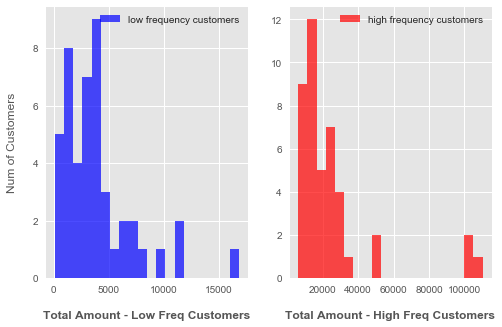

In [121]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(low_frequency['TotalAmount'], bins=20, color='b', alpha=0.7, label='low frequency customers')
ax1.set_xlabel('\nTotal Amount - Low Freq Customers', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(high_frequency['TotalAmount'], bins=20, color='r', alpha=0.7, label='high frequency customers')
ax2.set_xlabel('\nTotal Amount - High Freq Customers', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [254]:
print(scs.shapiro(high_frequency['TotalAmount']), scs.shapiro(low_frequency['TotalAmount']))

NameError: name 'high_frequency' is not defined

> With p-values below the alpha level (0.05) we reject H0 and have significant evidence to assume that the samples do not follow a normal distribution.

##### Levene test to check for equal variances
- H0: v1=v2

- Ha: v1!=v2

In [13]:
# Levene Test for testing homogeneity of variances
# I will be evaluating if the total amount comes from a normal distribution

scs.levene(high_frequency['TotalAmount'], low_frequency['TotalAmount'])

LeveneResult(statistic=11.818379956321802, pvalue=0.0009019045930232378)

> We have significant evidence to reject H0 and conclude that the variances in the samples are different.
Since the variances between the two groups are not equal, we cannot use a T-test

### Experiment 1: Monte Carlo Simulation

**After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality and equal variance assumptions.**

In [14]:
#get the mean difference 
mean_diff = high_frequency['TotalAmount'].mean() - low_frequency['TotalAmount'].mean()
mean_diff

21086.921466632968

- On average, high frequency customers spent $21086 more than low frequency customers.
- We will take 10000 random sample mean differences from our data and check if the random mean difference is greater than the study mean difference (high_frequency - low_frequency).
- If not many random sample mean differences are greater than the study mean difference, then we can conclude that the study mean difference is not due to chance
- We also calculate the p-value to check the percentage of random mean differences that are greater than the study mean difference

In [15]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0

for i in range(10000):
    sample_high = data1.sample(replace=False, n=len(high_frequency['TotalAmount']))
    sample_low = data1.drop(sample_high.index, axis=0)
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

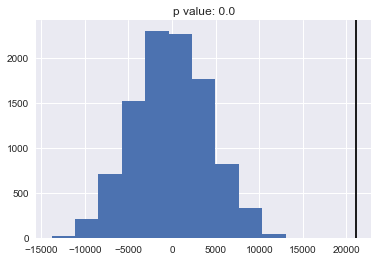

In [16]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

### Experiment 1: Conclusions 

- A Shapiro test and a Levene test were used to check normality and equal variance assumptions. The results from these tests along with the plotted histograms confirmed that the data did not come from a normal distribution 
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.0, therefore we have significant evidence to reject H0
- The conclusion of this experiment is that customers with more orders placed spend more than customers with less orders placed 
- An additional experiment will be performed to ensure that these results are not influenced by the customer's first order date

### Experiment 2: Data Exploration
For this experiment, we will analyze if the low frequency sample group was influenced by the new customer onboarding date

In [87]:
#DataFrame with order Id details and Order Date
#This will help explore further the frequency of customers
data2 = pd.read_sql_query('''SELECT o.Id, o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.Id
                            ;''', cnx)

In [88]:
data2['OrderDate'] = pd.to_datetime(data2['OrderDate'])

In [89]:
data2.head()

,Id,CustomerId,OrderDate,TotalAmount
0,10248,VINET,2012-07-04,440.00
1,10249,TOMSP,2012-07-05,1863.40
2,10250,HANAR,2012-07-08,1552.60
3,10251,VICTE,2012-07-08,654.06
4,10252,SUPRD,2012-07-09,3597.90


In [90]:
#select the customer IDs from the high and low frequency from the second dataset
High_freq = data2.loc[data2['CustomerId'].isin(high_frequency['CustomerId'])]
Low_freq = data2.loc[data2['CustomerId'].isin(low_frequency['CustomerId'])]

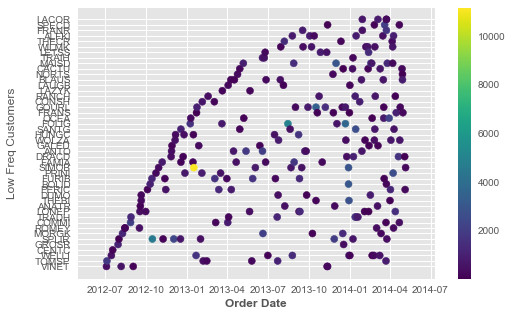

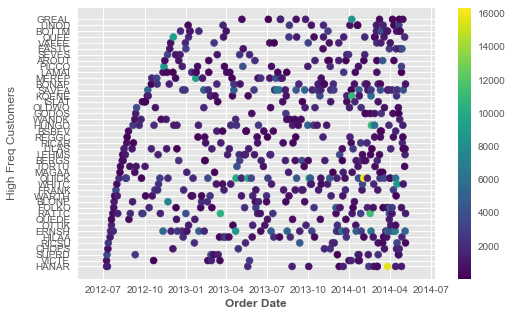

In [77]:
#Plot of random sample of low frequency and hight frequency customers 
plt.figure(figsize=(8, 5))
sc = plt.scatter(Low_freq['OrderDate'], Low_freq['CustomerId'], marker='o', c=Low_freq['TotalAmount'], cmap='viridis', vmin=Low_freq['TotalAmount'].min(), vmax=Low_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Low Freq Customers\n')
plt.colorbar(sc)
plt.show()

plt.figure(figsize=(8, 5))
sc2 = plt.scatter(High_freq['OrderDate'], High_freq['CustomerId'], marker='o', c=High_freq['TotalAmount'], cmap='viridis', vmin=High_freq['TotalAmount'].min(), vmax=High_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('High Freq Customers\n')
plt.colorbar(sc2)
plt.show()

> The plotted order IDs vs customer shows that there might be an influence in the number of orders by the date the customer started working with our store. We will make the assumption that most of the customers started working with Northwind by 07-2013 and we will do the hypothesis test on the new sample. 

##### Select new sample

Selecting orders placed after 2013-07-01 since 97% of the customers had placed at least one order by then

In [111]:
#Only orders places after 07-2013 will be considered
#Get the total sales amount per customer ID
#Get the count of number of orders placed by customer

data3 = pd.read_sql_query('''SELECT o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            WHERE o.OrderDate > '2013-07-01'
                            GROUP BY o.CustomerId
                            ;''', cnx) 

In [114]:
data3['CountOrders'].median()

11.0

In [115]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_frequency2 = data3.loc[data1['CountOrders'] > data3['CountOrders'].median()]
low_frequency2 = data3.loc[data1['CountOrders'] <= data3['CountOrders'].median()]

##### Histogram to check normality

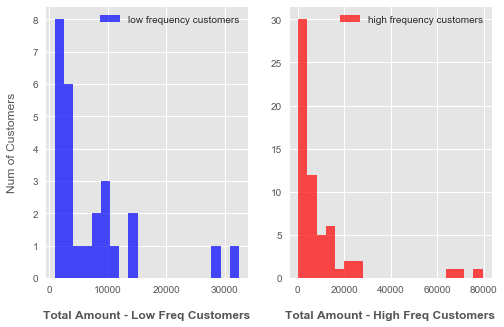

In [122]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(low_frequency2['TotalAmount'], bins=20, color='b', alpha=0.7, label='low frequency customers')
ax1.set_xlabel('\nTotal Amount - Low Freq Customers', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(high_frequency2['TotalAmount'], bins=20, color='r', alpha=0.7, label='high frequency customers')
ax2.set_xlabel('\nTotal Amount - High Freq Customers', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [124]:
print(scs.shapiro(high_frequency2['TotalAmount']), scs.shapiro(low_frequency2['TotalAmount']))

(0.5477457046508789, 2.0006945319200886e-12) (0.7365228533744812, 1.7483718693256378e-05)


> With p-values below the alpha level (0.05) we reject H0 and have significant evidence to assume that the samples do not follow a normal distribution.

### Experiment 2: Monte Carlo Simulation
After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality and equal variance assumptions.

In [125]:
#get the mean difference 
mean_diff = high_frequency2['TotalAmount'].mean() - low_frequency2['TotalAmount'].mean()
mean_diff

2374.1676131778077

- On average, high frequency customers spent $2374 more than low frequency customers.
- We will take 10000 random sample mean differences from our data and check if the random mean difference is greater than the study mean difference (high_frequency - low_frequency).
- If not many random sample mean differences are greater than the study mean difference, then we can conclude that the study mean difference is not due to chance
- We also calculate the p-value to check the percentage of random mean differences that are greater than the study mean difference

In [49]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0
for i in range(10000):
    sample_high = data3.sample(replace=False, n=len(high_frequency['TotalAmount']))
    sample_low = data3.drop(sample_high.index, axis=0)
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

NameError: name 'data3' is not defined

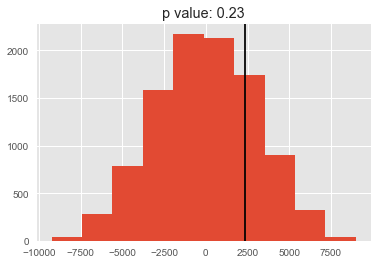

In [127]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

### Experiment 2: Conclusions 

- A Shapiro test and a histogram were used to test normality on the samples. The tests showed that the normality assumption was not met, therefore a non-parametric hypothesis test was used for experiment 2.
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.23, therefore we do not have significant evidence to reject H0.
- The conclusion of this experiment is that frequency of customer purchases does not have a significant influence in the sales amount of Northwind.  

### Business Recommendations for Hypothesis 1

- The same marketing scheme can be used for both high frequency and low frequency customers
- Invest money on new customer on-boarding 
- Consider creating a strategy geared to drive customers to make larger orders rather than more frequent ones in order to decrease shipping costs 

### Future work for Hypothesis 1

- What is the rate of growth in the number of new customers? 
- Study customer retention
- Growth of new customers per region (is there a region that is getting significantly more customers?)
- Study the rate of purchase per customer 

## Hypothesis 2 - Which employees bring in more revenue? UK or USA?
- $H_0: \mu_1 = \mu_2$ Sales amount is the same for USA and UK employees
- $H_a: \mu_1 > \mu_2$ USA employees sales amount is higher than UK employees sales amount

### Experiment 1: Data Exploration

In [16]:
c.execute("PRAGMA table_info('Employee')")
c.fetchall()

[(0, 'Id', 'INTEGER', 0, None, 1),
 (1, 'LastName', 'VARCHAR(8000)', 0, None, 0),
 (2, 'FirstName', 'VARCHAR(8000)', 0, None, 0),
 (3, 'Title', 'VARCHAR(8000)', 0, None, 0),
 (4, 'TitleOfCourtesy', 'VARCHAR(8000)', 0, None, 0),
 (5, 'BirthDate', 'VARCHAR(8000)', 0, None, 0),
 (6, 'HireDate', 'VARCHAR(8000)', 0, None, 0),
 (7, 'Address', 'VARCHAR(8000)', 0, None, 0),
 (8, 'City', 'VARCHAR(8000)', 0, None, 0),
 (9, 'Region', 'VARCHAR(8000)', 0, None, 0),
 (10, 'PostalCode', 'VARCHAR(8000)', 0, None, 0),
 (11, 'Country', 'VARCHAR(8000)', 0, None, 0),
 (12, 'HomePhone', 'VARCHAR(8000)', 0, None, 0),
 (13, 'Extension', 'VARCHAR(8000)', 0, None, 0),
 (14, 'Photo', 'BLOB', 0, None, 0),
 (15, 'Notes', 'VARCHAR(8000)', 0, None, 0),
 (16, 'ReportsTo', 'INTEGER', 0, None, 0),
 (17, 'PhotoPath', 'VARCHAR(8000)', 0, None, 0)]

In [34]:
#Create DataFrame for Hypothesis 2
data4 = pd.read_sql_query('''SELECT e.Id as 'EmployeeId', e.Country, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Employee' e
                            JOIN 'Order' o ON e.Id = o.EmployeeId
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY e.Id
                            ;''', cnx)

In [35]:
data4.head()

,EmployeeId,Country,TotalAmount
0,1,USA,192107.6045
1,2,USA,166537.7550
2,3,USA,202812.8430
3,4,USA,232890.8460
4,5,UK,68792.2825


In [36]:
data4['Country'].value_counts()

USA    5
UK     4
Name: Country, dtype: int64

In [38]:
dfUSA = data4.loc[data4['Country'] == 'USA']
dfUK = data4.loc[data4['Country'] == 'UK']

##### Histogram to check normality

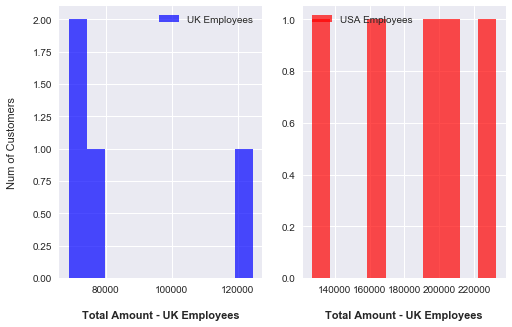

In [42]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))

ax1.hist(dfUK['TotalAmount'], color='b', alpha=0.7, label='UK Employees')
ax1.set_xlabel('\nTotal Amount - UK Employees', fontweight='bold')
ax1.set_ylabel('Num of Customers\n')
ax1.legend()

ax2.hist(dfUSA['TotalAmount'], color='r', alpha=0.7, label='USA Employees')
ax2.set_xlabel('\nTotal Amount - UK Employees', fontweight='bold')
ax2.legend();

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [43]:
print(scs.shapiro(dfUK['TotalAmount']), scs.shapiro(dfUSA['TotalAmount']))

(0.7545575499534607, 0.042571838945150375) (0.9839245080947876, 0.9544581174850464)


> dfUK has a p-value of 0.04, therefore we nahe enough evidence to reject H0 (dfUK does NOT come from a normal distribution). We will use a non-parametric test

### Experiment 1: Monte Carlo Simulation

**After inspection of the sample distributions we determined that a non-parametric method will be used since the sample distributions do not comply with the normality assumption.**

In [45]:
#get the mean difference 
mean_diff = dfUSA['TotalAmount'].mean() - dfUK['TotalAmount'].mean()
mean_diff

98096.83682499999

In [47]:
#Monte Carlo Simulation
sample_diffs = []
counter = 0

for i in range(10000):
    sampleUSA = data4.sample(replace=False, n=len(dfUSA['TotalAmount']))
    sampleUK = data4.drop(sampleUSA.index, axis=0)
    sample_diff = sampleUSA['TotalAmount'].mean() - sampleUK['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

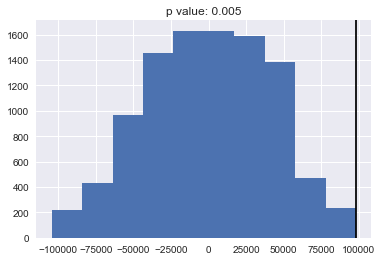

In [48]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p value: {np.round(counter / 10000, 3)}');

### Experiment 2: Conclusions 

- A Shapiro test and a histogram were used to test normality on the samples. The tests showed that the normality assumption was not met, therefore a non-parametric hypothesis test was used for this experiment.
- A Monte Carlo simulation was used to evaluate our hypothesis and ensure reliable results
- P-value = 0.005, therefore we do have significant evidence to reject H0.
- The conclusion of this experiment is that employees from the USA significantly bring more revenue than employees from UK

## Francis Hypothesis - Does order handling time affect the sales amount?

- H0 = Sales Amount for High order handling time >= Sales Amount for lower handling time 
- Ha = Sales Amount for High order handling time < Sales Amount for lower order handling time

Order handling time = ShippedDate - OrderedDate


In [ ]:
#Get the total amount per order ID
#Get the order handling time in days per order ID
#handling time = ShippedDate - OrderDate

data = pd.read_sql_query('''SELECT o.Id as OrderId, o.CustomerId, o.OrderDate, o.ShippedDate, 
                            julianday(o.ShippedDate) - julianday(o.OrderDate) as "HandlingTime",
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.Id
                            ;''', cnx)

In [ ]:
data.head()

In [ ]:
#get the median amount to create the samples
data['HandlingTime'].median()

In [ ]:
#create 2 sample groups 
#sample groups are divided by the median handling time. This will allow to check
#if the Total_Amount means between groups are significantly different

large_handling = data.loc[data['HandlingTime'] > data['HandlingTime'].median()]

small_handling = data.loc[data['HandlingTime'] <= data['HandlingTime'].median()]


In [ ]:
#Check normality in data
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.hist(small_handling['TotalAmount'], bins=100, color='b', alpha=0.5, label='small handling time')
ax2.hist(large_handling['TotalAmount'], bins=100, color='r', alpha=0.7, label='large handling time')
ax1.legend()
ax2.legend();

In [ ]:
#Take some sample means 
sample_means_small = []
sample_means_large = []

for i in range(50):
    samp = np.random.choice(small_handling['TotalAmount'], size=50).mean()
    sample_means_small.append(samp)
    
for i in range(50):
    samp = np.random.choice(large_handling['TotalAmount'], size=50).mean()
    sample_means_large.append(samp)

In [ ]:
sd_small = np.std(sample_means_small, ddof=1)
sd_large = np.std(sample_means_large, ddof=1)
print(sd_small, sd_large)

In [ ]:
print(sd_small, np.std(sample_means_small))
print(sd_large, np.std(sample_means_large))

In [ ]:
plt.figure(figsize=(5, 3))
plt.hist(sample_means_small, bins=20, color='r', alpha=0.5)
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(sample_means_large, bins=20, color='b', alpha=0.5)
plt.show();

#### Using Shapiro test for normality
- H0: distribution is normal
- Ha: distribution is not normal

In [ ]:
print(scs.shapiro(sample_means_small), scs.shapiro(sample_means_large))

With p-values greater than 0.05 we faild to reject H0; therefore, we have enough evidence to believe that the sample means come from a normal distribution.

#### Using the Levene test for equal variances of 2 distributions
- H0: v1=v2

- Ha: v1!=v2

## Francis Hypothesis2 - What are the two-products purchased together more often?


- H0: ProductId=60 mean units sold when ProductId=71 is purchased =< ProductId=60 mean units sold when ProductId=71 is NOT purchased (difference between means = zero)

> $H_0: \mu_d =< 0$

- Ha: ProductId=60 mean units sold when ProductId=71 is purchased > ProductId=60 mean units sold when ProductId=71 is NOT purchased

> $H_a:  \mu_d > 0$


Since I specify the direction of the difference, it's a **one-tailed** test.

### Experiment 1: Data Exploration

In [132]:
#Find out what the best seller product is
dfBestSeller = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, 
                            SUM(od.Quantity) as 'UnitsSold'
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            GROUP BY od.ProductId
                            ;''', cnx)

In [95]:
dfBestSeller.sort_values(by='UnitsSold', ascending=False)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
59,60,Camembert Pierrot,4,Dairy Products,1577
58,59,Raclette Courdavault,4,Dairy Products,1496
30,31,Gorgonzola Telino,4,Dairy Products,1397
55,56,Gnocchi di nonna Alice,5,Grains/Cereals,1263
15,16,Pavlova,3,Confections,1158
74,75,Rhönbräu Klosterbier,1,Beverages,1155
23,24,Guaraná Fantástica,1,Beverages,1125
39,40,Boston Crab Meat,8,Seafood,1103
61,62,Tarte au sucre,3,Confections,1083
70,71,Flotemysost,4,Dairy Products,1057


In [98]:
dfBestSeller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
ProductId       77 non-null int64
ProductName     77 non-null object
CategoryId      77 non-null int64
CategoryName    77 non-null object
UnitsSold       77 non-null int64
dtypes: int64(3), object(2)
memory usage: 3.1+ KB


> - There are 70 different products in the company. 
> - The best seller is  ProductId= 60-'Camembert Pierrot' with 1577 units sold.
> - Will find all the OrderIds that contain ProductId= 60-'Camembert Pierrot' and find the most frequent product bought with it

In [149]:
#Get all OrderIds that contain ProductId = 60
dfP60_OrderIds = pd.read_sql_query('''SELECT od.OrderId
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            WHERE ProductId = 60
                            ;''', cnx)

In [150]:
dfP60_OrderIds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 1 columns):
OrderId    51 non-null int64
dtypes: int64(1)
memory usage: 488.0 bytes


In [151]:
#Find all the ProductIds and the quantities sold for all the OrderIds that contained ProductId=60
#This will help find the product most selled with P60
dfBestSeller2 = pd.read_sql_query('''SELECT od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, 
                            SUM(od.Quantity) as 'UnitsSold'
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            WHERE od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            GROUP BY od.ProductId
                            ;''', cnx)

In [134]:
dfBestSeller2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
ProductId       63 non-null int64
ProductName     63 non-null object
CategoryId      63 non-null int64
CategoryName    63 non-null object
UnitsSold       63 non-null int64
dtypes: int64(3), object(2)
memory usage: 2.5+ KB


In [138]:
#Find the product that was paired the most times with ProductId=60
dfBestSeller2.sort_values(by='UnitsSold', ascending=False)

,ProductId,ProductName,CategoryId,CategoryName,UnitsSold
49,60,Camembert Pierrot,4,Dairy Products,1577
57,71,Flotemysost,4,Dairy Products,197
13,16,Pavlova,3,Confections,196
33,40,Boston Crab Meat,8,Seafood,187
25,31,Gorgonzola Telino,4,Dairy Products,165
0,1,Chai,1,Beverages,164
22,27,Schoggi Schokolade,3,Confections,135
20,24,Guaraná Fantástica,1,Beverages,132
32,39,Chartreuse verte,1,Beverages,129
8,10,Ikura,8,Seafood,117


> - ProductId=71-'Flotemysost' was the product most frequently bought with ProductId=60
> - Need to determine if the purchase of P71 increases the sales in P60

In [170]:
#Get the OrderIds where P60 and P71
#This will help classify the orderIds where P71 = yes or P71 = no
dfP71_OrderId = pd.read_sql_query('''SELECT DISTINCT od.OrderId 
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            WHERE od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            AND od.OrderId IN 
                                (SELECT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 71)
                            ;''', cnx)

In [172]:
dfP71_OrderId.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
OrderId    6 non-null int64
dtypes: int64(1)
memory usage: 128.0 bytes


In [173]:
#P60 with order Id
dfP60vsP71 = pd.read_sql_query('''SELECT od.OrderId, od.ProductId, p.ProductName, p.CategoryId, c.CategoryName, 
                            od.Quantity
                            FROM 'OrderDetail' od
                            JOIN 'Product' p ON p.Id = od.ProductId
                            JOIN 'Category' c ON c.Id = p.CategoryId
                            WHERE od.OrderId IN 
                                (SELECT DISTINCT od.OrderId
                                FROM 'OrderDetail' od
                                JOIN 'Product' p ON p.Id = od.ProductId
                                WHERE ProductId = 60)
                            AND od.ProductId = 60
                            ;''', cnx)

In [176]:
dfP60vsP71.head()

,OrderId,ProductId,ProductName,CategoryId,CategoryName,Quantity
0,10252,60,Camembert Pierrot,4,Dairy Products,40
1,10283,60,Camembert Pierrot,4,Dairy Products,35
2,10284,60,Camembert Pierrot,4,Dairy Products,20
3,10294,60,Camembert Pierrot,4,Dairy Products,21
4,10357,60,Camembert Pierrot,4,Dairy Products,8


In [241]:
dfwithP71 = dfP60vsP71.loc[dfP60vsP71['OrderId'].isin(list(dfP71_OrderId['OrderId']))]
dfwoP71 = dfP60vsP71.loc[~dfP60vsP71['OrderId'].isin(list(dfP71_OrderId['OrderId']))]

In [242]:
print(dfwithP71.shape, dfwoP71.shape)

(6, 6) (45, 6)


In [243]:
mu_withP71, mu_woP71 = np.mean(dfwithP71['Quantity']), np.mean( dfwoP71['Quantity'])
print(mu_withP71, mu_woP71)

39.166666666666664 29.822222222222223


In [244]:
sd_withP71, sd_woP71 = np.std(dfwithP71['Quantity']), np.std(dfwoP71['Quantity'])
print(sd_withP71, sd_woP71)

18.451889394374287 23.153870700059237


> From the sample  average and standard deviations we can see that the two groups are not so close in numbers. Need to investigate further to confirm if there is a real existing difference between groups.

$$\ Pooled Sample Var = \frac{(n_1-1)S_1^2 + (n_2-1)S_2^2 } {n_1 + n_2 -2} $$

In [250]:
def compute_n(alpha, beta, mu_0, mu_1, var):
    z_alpha = scs.norm.ppf(alpha)
    z_beta = scs.norm.ppf(beta)
    num = ((z_alpha+z_beta)**2)*var
    den = (mu_1 - mu_0)**2
    return num/den

alpha = .05 #Part of A/B test design
beta = .2 #This is to have a power of 80
mu_0 = mu_withP71 #Part of A/B test design
mu_1 = mu_woP71 #Part of A/B test design

numsample_var = (len(dfwithP71['Quantity'])-1)*(sd_withP71**2) + (len(dfwoP71['Quantity'])-1)*(sd_woP71**2) 
densample_var = ((len(dfwithP71['Quantity'])+len(dfwoP71['Quantity'])) -2)
sample_var = numsample_var / densample_var #from PooledSampleVar formula above

sample_var

516.139533887629

In [251]:
compute_n(alpha, beta, mu_0, mu_1, sample_var)

36.545027909053175

> We can see from computing the ideal number of n that we would need at least 36 samples. Will check the normality assumption and see if a Welch's Test can be performed given the difference in std and var

##### Histogram to check normality

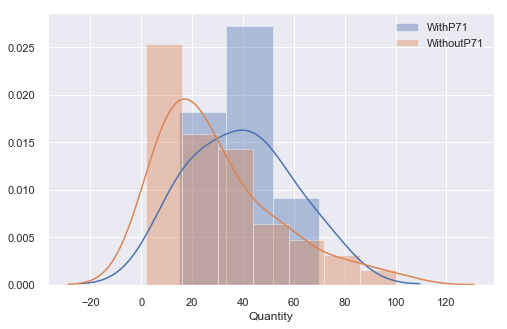

In [255]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})
sns.distplot(dfwithP71['Quantity'], label='WithP71')
sns.distplot(dfwoP71['Quantity'], label='WithoutP71') 
plt.legend()
plt.show();

##### Check Outliers

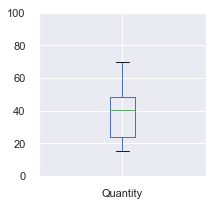

In [272]:
dfwithP71['Quantity'].plot(kind='box', ylim=(0, 100), figsize=(3,3));

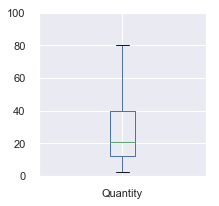

In [273]:
dfwoP71['Quantity'].plot(kind='box', ylim=(0, 100), figsize=(3,3));

##### Shapiro test to check normality
- H0: distribution is normal
- Ha: distribution is not normal

In [256]:
print(scs.shapiro(dfwithP71['Quantity']), scs.shapiro(dfwoP71['Quantity']))

(0.9605991244316101, 0.8243460655212402) (0.8918686509132385, 0.0005341130308806896)


##### Levene test to check for equal variances
- H0: v1=v2

- Ha: v1!=v2

In [257]:
scs.levene(dfwithP71['Quantity'], dfwoP71['Quantity'])

LeveneResult(statistic=0.06407726897311178, pvalue=0.801223004740049)

### Experiment 1: Welch's T-Test
- I will use a Welch's T-Test since my samples are not of equal size. 
- dfwithP71 passed the test for normality, dfwoP71 did not pass it. 
- Eventhough dfwoP71 did not come from a normal dustribution, I will continue using Welch's T-test since it remains robust for skewed distributions.

In [286]:
# calculating t-value and two-tailed p-value 
t, p_two = scs.ttest_ind(dfwithP71['Quantity'], dfwoP71['Quantity'], 
                           equal_var=False)
t

1.0429263972500478

In [280]:
Welc_num = np.mean(dfwithP71['Quantity']) - np.mean(dfwoP71['Quantity'])

In [287]:
Welc_dem = np.sqrt(((np.std((dfwithP71['Quantity']))**2)/len(dfwithP71['Quantity'])) + ((np.std(dfwoP71['Quantity'])**2)/len(dfwoP71['Quantity'])))

In [288]:
W = Welc_num / Welc_dem

In [289]:
W

1.127731120123044

# Sales over time test

In [50]:
data9 = pd.read_sql_query('''SELECT o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.OrderDate
                            ;''', cnx)

In [62]:
data9['OrderDate'] = pd.to_datetime(data9['OrderDate'])
# df['date_column'] = pd.to_datetime(df['date_column'])

In [64]:
# df['mnth_yr'] = df['date_column'].apply(lambda x: x.strftime('%B-%Y')) 
data9['mnth_yr'] = data9['OrderDate'].apply(lambda x: x.strftime('%B-%Y')) 

In [65]:
data9.head()

,OrderDate,TotalAmount,mnth_yr
0,2012-07-04,440.00,July-2012
1,2012-07-05,1863.40,July-2012
2,2012-07-08,2206.66,July-2012
3,2012-07-09,3597.90,July-2012
4,2012-07-10,1444.80,July-2012


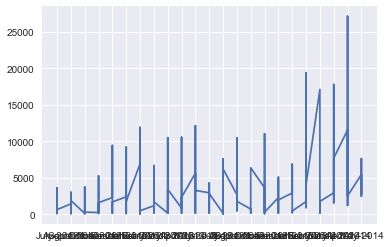

In [71]:
plt.figsize = (25,25)
plt.plot(data9['mnth_yr'], data9['TotalAmount'])
plt.show()